In [41]:
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow as tf
import os
import time
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
dir = "data"

data = {"Pale":[],
"Intermediate":[],
"Dark":[]}


for file in os.listdir(dir):
    if file[0] == "0":
        data["Pale"].append(tf.io.decode_png(tf.io.read_file(os.path.join(dir, file), name=None)))
    elif file[0] == "1":
        data["Intermediate"].append(tf.io.decode_png(tf.io.read_file(os.path.join(dir, file), name=None)))  
    else:
        data["Dark"].append(tf.io.decode_png(tf.io.read_file(os.path.join(dir, file), name=None)))


data["Pale"], data["Intermediate"], data["Dark"] = np.array(data["Pale"]), np.array(data["Intermediate"]), np.array(data["Dark"])

#On va entrainer sur x% des données et tester sur (100-x)% des données
x = 80

n_p, n_i, n_d = data["Pale"].shape[0], data["Intermediate"].shape[0], data["Dark"].shape[0]

train_pale, train_inter, train_dark = data["Pale"][:m.ceil((x/100)*n_p)], data["Intermediate"][:m.ceil((x/100)*n_i)], data["Dark"][:m.ceil((x/100)*n_d)]

test_pale, test_inter, test_dark = data["Pale"][m.ceil((x/100)*n_p):], data["Intermediate"][m.ceil((x/100)*n_i):], data["Dark"][m.ceil((x/100)*n_d):]

#plt.imshow(train_pale[0])


2022-03-30 01:52:57.770916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-30 01:52:57.770987: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 01:52:57.771030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nicolas-Lenovo-IdeaPad-S340-15API): /proc/driver/nvidia/version does not exist
2022-03-30 01:52:57.773281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [4]:
#cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    #image = tf.image.resize(image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    #image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image
    
def preprocess_image_test(image):
    image = normalize(image)
    return image




In [9]:
train_pale_tf = tf.data.Dataset.from_tensor_slices(train_pale)
test_pale_tf = tf.data.Dataset.from_tensor_slices(test_pale)

train_dark_tf = tf.data.Dataset.from_tensor_slices(train_dark)
test_dark_tf = tf.data.Dataset.from_tensor_slices(test_dark)






In [10]:
train_pale_tf = train_pale_tf.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_pale_tf = test_pale_tf.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dark_tf = train_dark_tf.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dark_tf = test_dark_tf.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



In [11]:
sample_pale = next(iter(train_pale_tf))
sample_dark = next(iter(train_dark_tf))

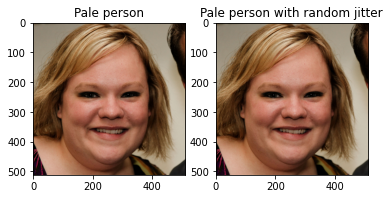

In [17]:
plt.subplot(121)
plt.title('Pale person')
plt.imshow(sample_pale[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Pale person with random jitter')
plt.imshow(random_jitter(sample_pale[0]) * 0.5 + 0.5)

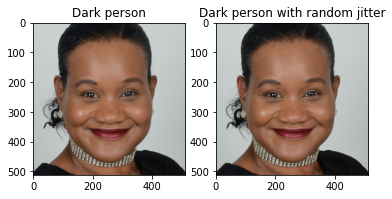

In [18]:
plt.subplot(121)
plt.title('Dark person')
plt.imshow(sample_dark[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Dark person with random jitter')
plt.imshow(random_jitter(sample_dark[0]) * 0.5 + 0.5)

In [21]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


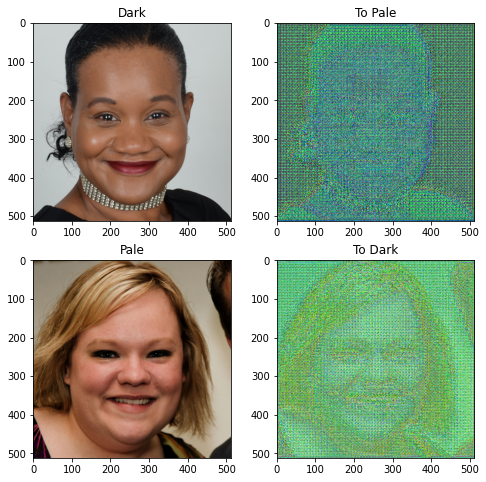

In [22]:
to_dark = generator_g(sample_pale)
to_pale = generator_f(sample_dark)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_dark, to_pale, sample_pale, to_dark]
title = ['Dark', 'To Pale', 'Pale', 'To Dark']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

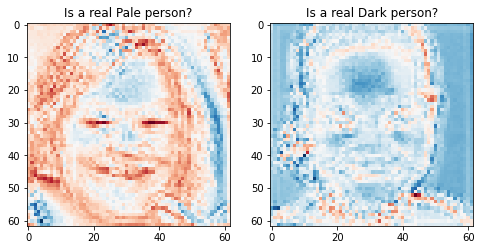

In [24]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Pale person?')
plt.imshow(discriminator_y(sample_pale)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Dark person?')
plt.imshow(discriminator_x(sample_dark)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [25]:
LAMBDA = 10


In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [28]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [29]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [30]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


In [31]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [33]:
EPOCHS = 40


In [34]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [35]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

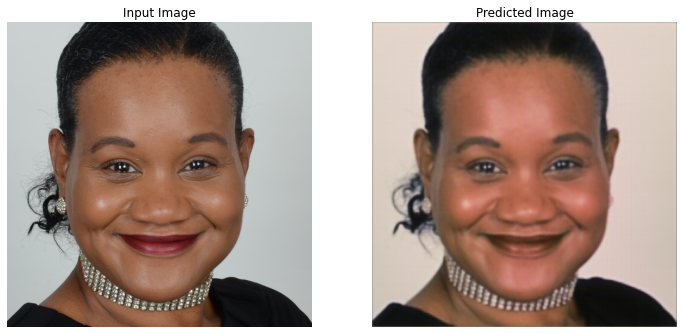

Time taken for epoch 7 is 287.68659257888794 sec

..

KeyboardInterrupt: 

In [42]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_dark_tf, train_pale_tf)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_dark)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))